In [4]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os
import pickle

# Func

In [5]:
def load_metadata(root_path, paradigm_setting, session_num):
    meta = pd.read_excel(root_path + 'mat/adp_dataset_master.xlsx', index_col=None)
    meta = meta[meta.paradigm == paradigm_setting].reset_index()
    meta = meta[['mouse','date','area','num']]

    meta.mouse = meta.mouse.astype(int)
    
    if isinstance(session_num, int):
        meta.date = meta.date.astype(int).astype(str) + '_00' + meta.num.astype(int).astype(str) + '_caiman'
        meta.num = meta.num.astype(int)
        meta = meta.loc[meta['num'] == session_num].reset_index()
    elif session_num == '':
        meta.date = meta.date.astype(int).astype(str) + '_caiman'
        meta = meta.head(1) # multisession, only keep one metadata
    return meta

In [6]:
def df_adp_mag(adp_mag, dfof_ad, dfof_tg):
    mag = adp_mag.flatten('F')
    ad = dfof_ad.flatten('F')
    tg = dfof_tg.flatten('F')

    cell_num = [np.arange(adp_mag.shape[0])] * adp_mag.shape[1]
    cell_num = np.concatenate(cell_num)
    stim = [np.arange(nstim)] * adp_mag.shape[0]
    stim_flat = np.sort([item for sublist in stim for item in sublist])
    
    df = pd.DataFrame({'cell':cell_num ,'stim':stim_flat, 'ad':ad, 'tg':tg, 'mag':mag, 'abs_mag':np.abs(mag)})
    return stim_flat, mag, ad, df


def threshold_adp_mag(df, dfof_threshold=0.00025, adp_threshold=10): 
    '''no threshold for dfof_ad bc too few shared stim for side A/B'''
    df_th = df.copy()
    # df_th.loc[df_th[(df.ad) < dfof_threshold].index.to_numpy(),'mag'] = np.nan # not threshold by abs, bc 1-tail ttest originally
    df_th.loc[df_th[np.abs(df.mag) > adp_threshold].index.to_numpy(),'mag'] = np.nan # bug / todo: fix vis_ad and filter normally by vis_ad, not filter by adp_mag
    
    mag_mean = df_th[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
    mag_median = df_th[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
    mag_std = df_th[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
    mag_sem = df_th[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
    return df_th, mag_mean, mag_median, mag_std, mag_sem

# Load

In [7]:
root_path = 'C:/Users/ll357/Documents/inter/'
meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num='')
print(meta)

dir_name = root_path + 'mat/'
iset = 0
dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

dfof_trialwise = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'resp_base_trialwise' + '.mat'))
# dfof_trialwise.keys(), dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape

dfof_ad_trial = dfof_trialwise['dfof_ad_trial'] - dfof_trialwise['dfof_base_trial'] # should subtract baseline!
dfof_tg_trial = dfof_trialwise['dfof_tg_trial'] - dfof_trialwise['dfof_base2_trial']

ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]
print(f'{ncell} cells, {nstim} stimuli')

with open('vis_img_driven.pickle', 'rb') as f:
    img_driven = pickle.load(f)
    vis_driven = pickle.load(f)
vis_driven.shape, img_driven.shape, 


   mouse           date area  num
0   1350  211222_caiman   V1  2.0
324 cells, 30 stimuli


((324, 1), (324, 30))

In [8]:
# test whether subtracting baseline: yes

dfof_ad = np.empty((ncell, nstim))
dfof_tg = np.empty((ncell, nstim))
adp = np.empty((ncell, nstim))

for icell in np.arange(ncell):
    for istim in np.arange(nstim):
        dfof_ad[icell,istim] = np.mean(dfof_ad_trial[icell,istim])
        dfof_tg[icell,istim] = np.mean(dfof_tg_trial[icell,istim])
        adp[icell,istim] = (dfof_tg[icell,istim] - dfof_ad[icell,istim]) / (dfof_ad[icell,istim] + 1e-7)

vis_driven_mask = vis_driven.copy().astype(float).flatten() # apply vis driven mask -> non-vis cells = nan
vis_driven_mask[vis_driven_mask==0] = np.nan

adp = adp * vis_driven_mask.reshape(ncell,1)
adp[np.abs(adp) > 10] = np.nan
np.nanmean(adp), np.nanmedian(adp)

(-0.7069438092392529, -0.760057185439826)

# split side A/B bootstrap

In [9]:
def split_correlate_side(mode, niter=50):

    dfof_ad_side_both = np.empty((ncell, nstim))
    dfof_ad_sideA = np.empty((ncell, nstim))
    dfof_ad_sideB = np.empty((ncell, nstim))
    dfof_tg_sideA = np.empty((ncell, nstim))
    dfof_tg_sideB = np.empty((ncell, nstim))

    niter = 50 # 9 min 100 iter, 6 min 50 iter, 1 min 10 iter
    corr_pearson_iter = np.zeros((1, ncell))
    p_pearson_iter = np.zeros((1, ncell))
    corr_spearman_iter = np.zeros((1, ncell))
    nstim_shared_iter = np.zeros((1, ncell))

    for i in tqdm(np.arange(niter)):
        for icell in np.arange(ncell):
            for istim in np.arange(nstim):
                ntrial_cond = dfof_ad_trial[icell,istim].shape[0]
                dfof_ad_side_both[icell,istim] = np.mean(dfof_ad_trial[icell,istim])

                idx_trial = np.random.choice(np.arange(ntrial_cond), size=ntrial_cond//2, replace=False)
                dfof_ad_sideA[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial,:])
                dfof_tg_sideA[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial,:])

                idx_trial_diff = np.setdiff1d(np.arange(ntrial_cond), idx_trial)
                dfof_ad_sideB[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial_diff,:])
                dfof_tg_sideB[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial_diff,:])

        if mode == 'adp':
            adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_ad_sideA + 1e-7) # (R2-R1)/(R1+epsilon)
            adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_ad_sideB + 1e-7)
        elif mode == 'adp_alt':
            adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_tg_sideA + dfof_ad_sideA + 1e-7) # (R2-R1)/(R1+R2)
            adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_tg_sideB + dfof_ad_sideB + 1e-7)
        elif mode == 'adp_stable':
            adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_ad_side_both + 1e-7) # R1 denominator should be stable, so use both sides
            adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_ad_side_both + 1e-7)
        elif mode == 'ad':
            adp_sideA = dfof_ad_sideA # grating tg noad is like bunnytop ad: 8 orientations, unadapted
            adp_sideB = dfof_ad_sideB
        elif mode == 'tg':
            adp_sideA = dfof_tg_sideA # grating tg is like bunnytop tg: 8 orientations, adapted
            adp_sideB = dfof_tg_sideB

        _, _, _, df_sideA = df_adp_mag(adp_sideA, dfof_ad_sideA, dfof_tg_sideA)
        _, _, _, df_sideB = df_adp_mag(adp_sideB, dfof_ad_sideB, dfof_tg_sideB)

        corr_pearson_pop = []
        p_pearson_pop = []
        corr_spearman_pop = []
        nstim_shared = []

        for icell in np.arange(ncell):
            df_sideA_cell = df_sideA.loc[df_sideA['cell'] == icell]
            df_sideB_cell = df_sideB.loc[df_sideB['cell'] == icell]
            _, mag_mean_sideA_cell, _, _, _ = threshold_adp_mag(df_sideA_cell, dfof_threshold=0, adp_threshold=10) # dfof thresh = 0 bc already vis driven
            _, mag_mean_sideB_cell, _, _, _ = threshold_adp_mag(df_sideB_cell, dfof_threshold=0, adp_threshold=10)

            not_nan_mask = (~np.isnan(mag_mean_sideA_cell)) & (~np.isnan(mag_mean_sideB_cell))
            nstim_shared.append(sum(not_nan_mask))

            corr_pearson_cell, p_pearson_cell = stats.pearsonr(mag_mean_sideA_cell[not_nan_mask], mag_mean_sideB_cell[not_nan_mask])
            corr_spearman_cell, _ = stats.spearmanr(mag_mean_sideA_cell[not_nan_mask], mag_mean_sideB_cell[not_nan_mask]) # spearman p is only "probably reasonable for datasets larger than 500"
            corr_pearson_pop.append(corr_pearson_cell)
            p_pearson_pop.append(p_pearson_cell)
            corr_spearman_pop.append(corr_spearman_cell)
            
        nstim_shared_iter = np.vstack((nstim_shared_iter, nstim_shared))
        corr_pearson_iter = np.vstack((corr_pearson_iter, corr_pearson_pop))
        p_pearson_iter = np.vstack((p_pearson_iter, p_pearson_pop))
        corr_spearman_iter = np.vstack((corr_spearman_iter, corr_spearman_pop))

    vis_driven_mask = vis_driven.copy().astype(float).flatten() # apply vis driven mask -> non-vis cells = nan
    vis_driven_mask[vis_driven_mask==0] = np.nan
    nstim_shared_iter = nstim_shared_iter[1:,:] * vis_driven_mask # remove the first row of zeros
    corr_pearson_iter = corr_pearson_iter[1:,:] * vis_driven_mask
    p_pearson_iter = p_pearson_iter[1:,:] * vis_driven_mask
    corr_spearman_iter = corr_spearman_iter[1:,:] * vis_driven_mask

    return nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter

## adp

In [244]:
# nstim_shared_adp = nstim_shared_iter.copy()
# corr_pearson_adp = corr_pearson_iter.copy()
# p_pearson_adp = p_pearson_iter.copy()
# corr_spearman_adp = corr_spearman_iter.copy()

# nstim_shared_iter = nstim_shared_adp
# corr_pearson_iter = corr_pearson_adp
# p_pearson_iter = p_pearson_adp
# corr_spearman_iter = corr_spearman_adp

0.030246913580246913

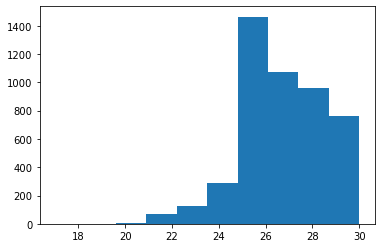

In [245]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

In [251]:
def mean_confidence_interval(data, confidence=0.95): # find 95% CI among iterations
    a = 1.0 * np.array(data)
    n = a.shape[0]
    m = np.nanmean(a, axis=0)
    se = stats.sem(a, axis=0, nan_policy='omit')
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

C:\Users\ll357\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


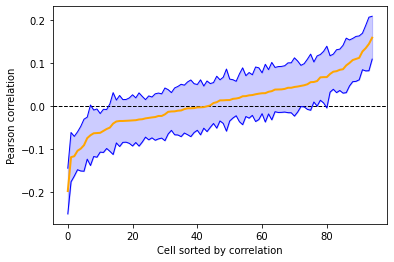

In [250]:
corr_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_avg_sort_id = np.argsort(corr_avg)
corr_avg_sort = corr_avg[corr_avg_sort_id]
# corr_sem = np.nanstd(corr_pearson_iter, axis=0) / np.sqrt(corr_pearson_iter.shape[0])
# corr_sem_sort = corr_sem[corr_avg_sort_id]
_, CI_low, CI_high = mean_confidence_interval(corr_pearson_iter)
CI_low_sort = CI_low[corr_avg_sort_id]
CI_high_sort = CI_high[corr_avg_sort_id]

plt.plot(np.arange(ncell), corr_avg_sort, color='orange', zorder=10, linewidth=2)
plt.plot(np.arange(ncell), CI_low_sort, color='b', zorder=10, linewidth=1)
plt.plot(np.arange(ncell), CI_high_sort, color='b', zorder=10, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_sort, CI_high_sort, color='b', alpha=0.2) # fill color between CI

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson correlation');

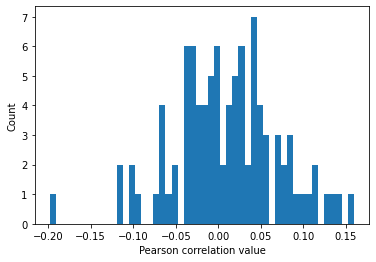

In [252]:
plt.hist(corr_avg, 50);
plt.xlabel('Pearson correlation value')
plt.ylabel('Count');

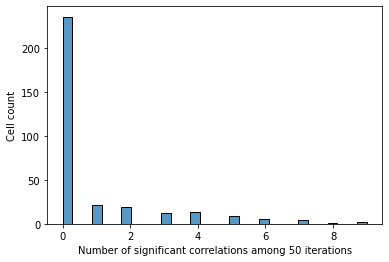

In [253]:
sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig);
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

# plt.figure(figsize=(10,15))
# plt.imshow(p_pearson_iter.T < 0.05); plt.colorbar()


0.01765432098765432

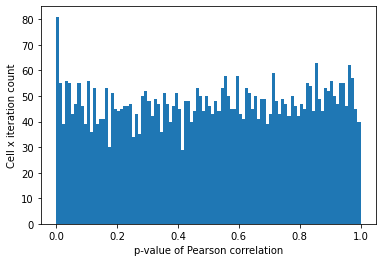

In [254]:
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## adp alt

In [10]:
nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='adp_alt', niter=50)

# nstim_shared_adp = nstim_shared_iter.copy()
# corr_pearson_adp = corr_pearson_iter.copy()
# p_pearson_adp = p_pearson_iter.copy()
# corr_spearman_adp = corr_spearman_iter.copy()

# nstim_shared_iter = nstim_shared_adp
# corr_pearson_iter = corr_pearson_adp
# p_pearson_iter = p_pearson_adp
# corr_spearman_iter = corr_spearman_adp

100%|██████████| 50/50 [03:33<00:00,  4.26s/it]


0.031234567901234567

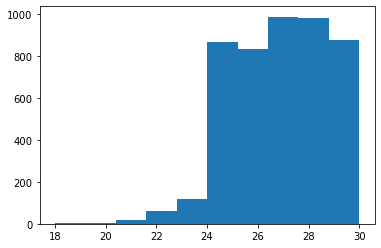

In [11]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

In [12]:
def mean_confidence_interval(data, confidence=0.95): # find 95% CI among iterations
    a = 1.0 * np.array(data)
    n = a.shape[0]
    m = np.nanmean(a, axis=0)
    se = stats.sem(a, axis=0, nan_policy='omit')
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

C:\Users\ll357\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
C:\Users\ll357\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


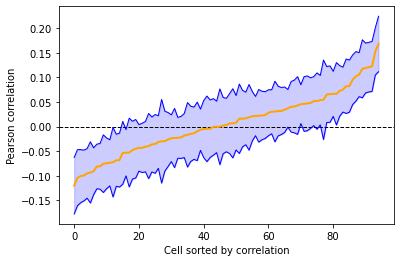

In [13]:
corr_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_avg_sort_id = np.argsort(corr_avg)
corr_avg_sort = corr_avg[corr_avg_sort_id]
# corr_sem = np.nanstd(corr_pearson_iter, axis=0) / np.sqrt(corr_pearson_iter.shape[0])
# corr_sem_sort = corr_sem[corr_avg_sort_id]
_, CI_low, CI_high = mean_confidence_interval(corr_pearson_iter)
CI_low_sort = CI_low[corr_avg_sort_id]
CI_high_sort = CI_high[corr_avg_sort_id]

plt.plot(np.arange(ncell), corr_avg_sort, color='orange', zorder=10, linewidth=2)
plt.plot(np.arange(ncell), CI_low_sort, color='b', zorder=10, linewidth=1)
plt.plot(np.arange(ncell), CI_high_sort, color='b', zorder=10, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_sort, CI_high_sort, color='b', alpha=0.2) # fill color between CI

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson correlation');

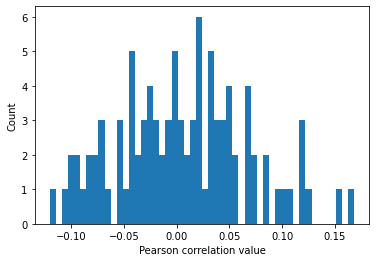

In [14]:
plt.hist(corr_avg, 50);
plt.xlabel('Pearson correlation value')
plt.ylabel('Count');

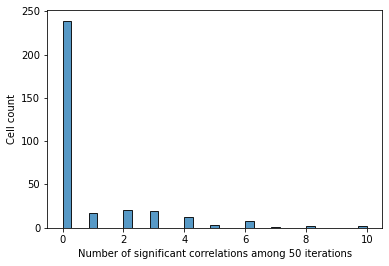

In [16]:
sig = np.sum(p_pearson_iter < 0.05, axis=0)
niter = 50
sns.histplot(sig);
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

# plt.figure(figsize=(10,15))
# plt.imshow(p_pearson_iter.T < 0.05); plt.colorbar()


0.016666666666666666

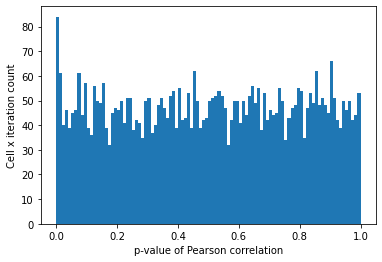

In [17]:
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## adp stable

In [18]:
nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='adp_stable', niter=50)

# nstim_shared_adp = nstim_shared_iter.copy()
# corr_pearson_adp = corr_pearson_iter.copy()
# p_pearson_adp = p_pearson_iter.copy()
# corr_spearman_adp = corr_spearman_iter.copy()

# nstim_shared_iter = nstim_shared_adp
# corr_pearson_iter = corr_pearson_adp
# p_pearson_iter = p_pearson_adp
# corr_spearman_iter = corr_spearman_adp

100%|██████████| 50/50 [03:33<00:00,  4.28s/it]


0.04061728395061728

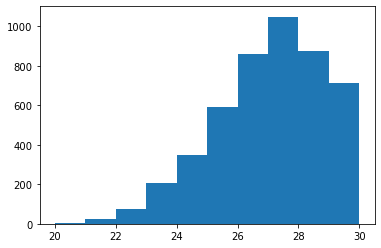

In [19]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

In [20]:
def mean_confidence_interval(data, confidence=0.95): # find 95% CI among iterations
    a = 1.0 * np.array(data)
    n = a.shape[0]
    m = np.nanmean(a, axis=0)
    se = stats.sem(a, axis=0, nan_policy='omit')
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

C:\Users\ll357\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
C:\Users\ll357\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


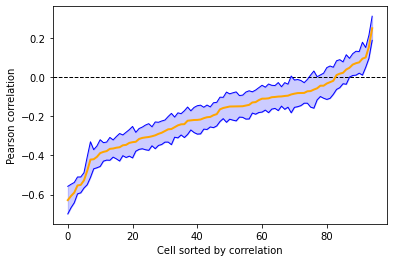

In [21]:
corr_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_avg_sort_id = np.argsort(corr_avg)
corr_avg_sort = corr_avg[corr_avg_sort_id]
# corr_sem = np.nanstd(corr_pearson_iter, axis=0) / np.sqrt(corr_pearson_iter.shape[0])
# corr_sem_sort = corr_sem[corr_avg_sort_id]
_, CI_low, CI_high = mean_confidence_interval(corr_pearson_iter)
CI_low_sort = CI_low[corr_avg_sort_id]
CI_high_sort = CI_high[corr_avg_sort_id]

plt.plot(np.arange(ncell), corr_avg_sort, color='orange', zorder=10, linewidth=2)
plt.plot(np.arange(ncell), CI_low_sort, color='b', zorder=10, linewidth=1)
plt.plot(np.arange(ncell), CI_high_sort, color='b', zorder=10, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_sort, CI_high_sort, color='b', alpha=0.2) # fill color between CI

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson correlation');

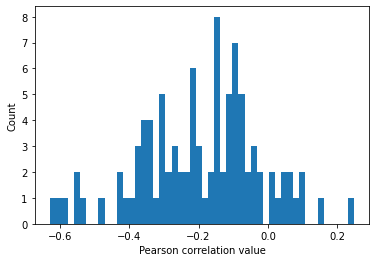

In [22]:
plt.hist(corr_avg, 50);
plt.xlabel('Pearson correlation value')
plt.ylabel('Count');

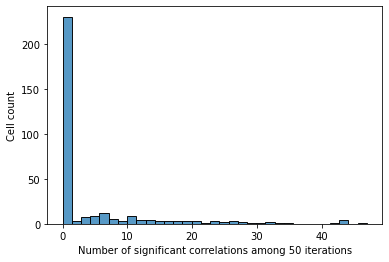

In [23]:
sig = np.sum(p_pearson_iter < 0.05, axis=0)
niter = 50
sns.histplot(sig);
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

# plt.figure(figsize=(10,15))
# plt.imshow(p_pearson_iter.T < 0.05); plt.colorbar()


0.08728395061728395

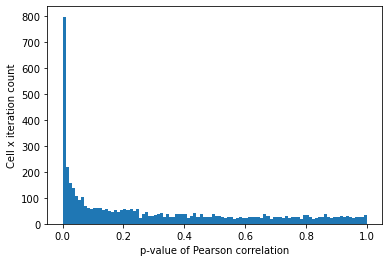

In [24]:
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## resp ad

In [255]:
# nstim_shared_resp_ad = nstim_shared_iter.copy()
# corr_pearson_resp_ad = corr_pearson_iter.copy()
# p_pearson_resp_ad = p_pearson_iter.copy()
# corr_spearman_resp_ad = corr_spearman_iter.copy()

# nstim_shared_iter = nstim_shared_resp_ad
# corr_pearson_iter = corr_pearson_resp_ad
# p_pearson_iter = p_pearson_resp_ad
# corr_spearman_iter = corr_spearman_resp_ad

0.0

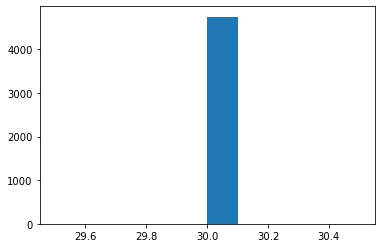

In [239]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

C:\Users\ll357\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
C:\Users\ll357\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


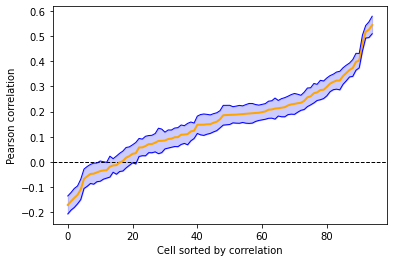

In [256]:
corr_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_avg_sort_id = np.argsort(corr_avg)
corr_avg_sort = corr_avg[corr_avg_sort_id]
# corr_sem = np.nanstd(corr_pearson_iter, axis=0) / np.sqrt(corr_pearson_iter.shape[0])
# corr_sem_sort = corr_sem[corr_avg_sort_id]
_, CI_low, CI_high = mean_confidence_interval(corr_pearson_iter)
CI_low_sort = CI_low[corr_avg_sort_id]
CI_high_sort = CI_high[corr_avg_sort_id]

plt.plot(np.arange(ncell), corr_avg_sort, color='orange', zorder=10, linewidth=2)
plt.plot(np.arange(ncell), CI_low_sort, color='b', zorder=10, linewidth=1)
plt.plot(np.arange(ncell), CI_high_sort, color='b', zorder=10, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_sort, CI_high_sort, color='b', alpha=0.2) # fill color between CI

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson correlation');

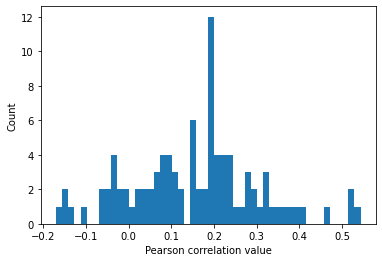

In [257]:
plt.hist(corr_avg, 50);
plt.xlabel('Pearson correlation value')
plt.ylabel('Count');

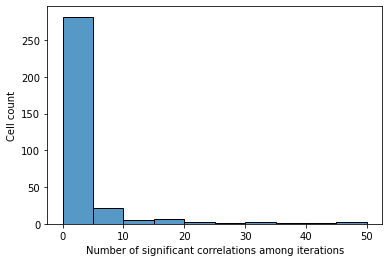

In [258]:
# plt.imshow(p_pearson_iter[:,:5], cmap='viridis', aspect='auto')
# plt.colorbar()
# p_pearson_iter.shape

sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig);
plt.xlabel('Number of significant correlations among iterations')
plt.ylabel('Cell count');

# plt.figure(figsize=(10,15))
# plt.imshow(p_pearson_iter.T < 0.05); plt.colorbar()


In [243]:
sum(sig>10)#, sum(sig>20)

20

0.0445679012345679

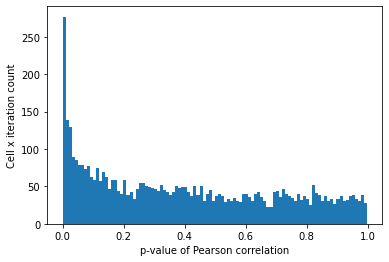

In [259]:
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## resp tg

In [260]:
# nstim_shared_resp_tg = nstim_shared_iter.copy()
# corr_pearson_resp_tg = corr_pearson_iter.copy()
# p_pearson_resp_tg = p_pearson_iter.copy()
# corr_spearman_resp_tg = corr_spearman_iter.copy()

# nstim_shared_iter = nstim_shared_resp_tg
# corr_pearson_iter = corr_pearson_resp_tg
# p_pearson_iter = p_pearson_resp_tg
# corr_spearman_iter = corr_spearman_resp_tg

0.0

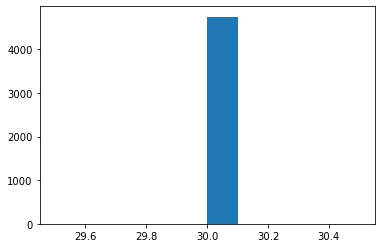

In [230]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

C:\Users\ll357\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
C:\Users\ll357\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


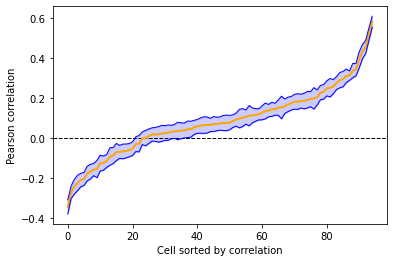

In [261]:
corr_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_avg_sort_id = np.argsort(corr_avg)
corr_avg_sort = corr_avg[corr_avg_sort_id]
# corr_sem = np.nanstd(corr_pearson_iter, axis=0) / np.sqrt(corr_pearson_iter.shape[0])
# corr_sem_sort = corr_sem[corr_avg_sort_id]
_, CI_low, CI_high = mean_confidence_interval(corr_pearson_iter)
CI_low_sort = CI_low[corr_avg_sort_id]
CI_high_sort = CI_high[corr_avg_sort_id]

plt.plot(np.arange(ncell), corr_avg_sort, color='orange', zorder=10, linewidth=2)
plt.plot(np.arange(ncell), CI_low_sort, color='b', zorder=10, linewidth=1)
plt.plot(np.arange(ncell), CI_high_sort, color='b', zorder=10, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_sort, CI_high_sort, color='b', alpha=0.2) # fill color between CI

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson correlation');

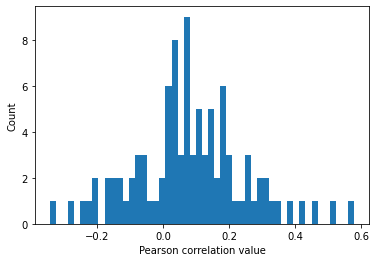

In [232]:
plt.hist(corr_avg, 50);
plt.xlabel('Pearson correlation value')
plt.ylabel('Count');

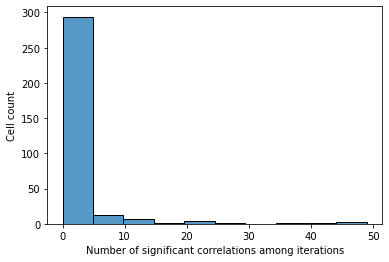

In [233]:
# plt.imshow(p_pearson_iter[:,:5], cmap='viridis', aspect='auto')
# plt.colorbar()
# p_pearson_iter.shape

sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig);
plt.xlabel('Number of significant correlations among iterations')
plt.ylabel('Cell count');

# plt.figure(figsize=(10,15))
# plt.imshow(p_pearson_iter.T < 0.05); plt.colorbar()


In [236]:
sum(sig>10)

17

0.03388888888888889

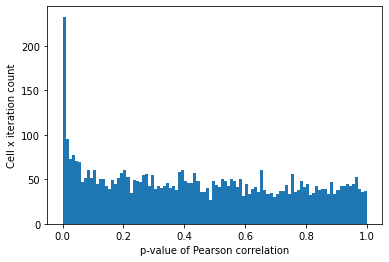

In [237]:
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())